# Binary Classification Guassian Mixture Simulation Study

| Course: | ID: | Name | Net Id: | Email: |
|-|-|-|-|-|
| Practical Statistical Learning | STAT 542 | John James | 6998 | jtjames2@illinois.edu |


## Introduction

This simulation study is an extension of the Nearest Neighbor Methods simulation study from chapter 2 of the Elements of Statistical Learning. The objective of this study is to evaluate the performance of the following algorithms in a binary classification context.

- Linear Regression
- Quadratic Regression
- k-Nearest Neighbors
- Bayes Rule
- Logistic Regression

The logistic regression algorithm serves as a baseline by which the above methods will be evaluated. 

### Data

The training data $X∈R2$ and $Y=(0,1)$ was generated from a mixture of 10 bivariate Gaussian distributions, the density function given by:
$$\frac{1}{10}\displaystyle\sum_{i=1}^{10}\bigg(\frac{1}{\sqrt{2\pi s^2}}\bigg)^2 e^{-\|x-m_{kl}\|^2/(2s^2)}$$

Components are uncorrelated with different means i.e. $X|Y=k,Z=l∼N(m_{kl},s^2I_2),X|Y=k,Z=l∼N(m_{kl},s^2I_2),$
- where $k=0,1,l=1:10,P(Y=k)=1/2,\text{and }P(Z=1)=1/10.$

The two-dimensional Gaussian centers for $l=1,...,10$ are distributed as follows:
$$m_{0l}\text{ i.i.d.} \sim \mathcal{N}((0,1)^T,\sigma^2 I_2)$$ 
$$m_{1l}\text{ i.i.d.} \sim \mathcal{N}((1,0)^T,\sigma^2 I_2)$$   

Simulations will be conducted for *centers* variance $\sigma = (1, 1.5, 2, 4)$. The variance in the *data* is computed as $s^2=\sigma^2/5$.


## Methods

### Environment

All experiments were performed on:

| Processor:        | Intel® Xeon® CPU X5650 @ 2.67Ghz (Dual   Processors) |
| ----------------- | ---------------------------------------------------- |
| Installed RAM:    | 128 GB                                               |
| Operating System: | Windows 10 Professional Build 19041.804              |
| System Type:      | 64-bit operating system, x64-based processor         |

The software was implemented in Python 3.9.

### Reproducibility

A seed was set at instantiation at 6998, the last four digits of the author's University ID. During the data generation process, the seed was incremented by 1 at each iteration to ensure that the pseudorandom process produced different data for each simulation.

### Sofware Packages
As shown below, several core Python packages provided data structures. Third party packages such as numpy and Scikit-Learn provide numerical methods as well as modeling. As required, the 10-Fold cross-validation was coded in Python from scratch.



In [1]:
from abc import ABC, abstractmethod
from collections import OrderedDict
from IPython.display import display, HTML, Markdown
import seaborn as sns
from sklearn import linear_model as lm
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


### Learning Algorithm Overview

The aim of the learning algorithm was to:

- Generate $X\in\mathbb{R}^2$ 10-Gaussian Mixture Models for 20 simulations
- Evaluate performance of the algorithms mentioned above
- Find optimal $k$-value for k-Nearest Neighbors via 10-Fold Cross Validation.

#### Parameters

This learning algorithm was parameterized as follows:

- random_state = 6998 (seed for reproducibility)
- $n\text{-simulations}$: = 20
- $n\text{-gaussians}$: = 10
- $\sigma\text{-centers}$: = 2
- $\sigma\text{-data}$: = $\sqrt{\frac{4}{5}}$
- $k\text{-folds}$: = 10
- $n\text{-training}$: 100 (per class)
- $n\text{-test}$: 5000 (per class)

#### Process

Upon instantiation,  a data generation step creates the centers for the 10 Gaussian Mixture Models. During each of the following 20 simulations, data were generated, and the algorithms were trained and evaluated.  The overall methodology is summarized in the following pseudocode.

1. Initialize parameters
2. Generate centers
3. For i=0; i<$n\text{-simulations}$; ++i
   1. Generates data
   2. Train and evaluate Linear Regression
   3. Train and evaluate Quadratic Regression
   4. Train and evaluate Bayes' Rule 
   5. Train and evaluate k-Nearest Neighbors
   6. Train and evaluate Logistic Regression
4. Report results

#### Output

Accuracy and Area Under the ROC Curve (AUC) were the performance measures used to evaluate performance. As such, the algorithm produces:

- Data: The training data for two randomly selected simulations are rendered via scatterplot
- Performance: 
  - Line plots showing the training and test scores by simulation
  - Box plots evincing the distribution of training and test scores
  - Descriptive statistics for training and test scores
- k-Nearest Neighbors
  - The optimal k-value is computed via 10-fold cross-validation and presented
  - Descriptive statistics for the k-values 

---

### Learning Algorithm Detail

The learning algorithm is comprised of the following modules:

| Module        | Class                | Description                                                  |
| ------------- | -------------------- | ------------------------------------------------------------ |
| Data          | DataGen              | Generates Guassian centers and the data                      |
|               | Kfold                | Generates the data for 10 Fold Cross-Validation              |
| Model         | Linear Regression    | Trains and scores linear regression model                    |
|               | Quadratic Regression | Trains and scores quadratic regression model                 |
|               | Bayes' Rule          | Trains and scores Bayes' Rule model                          |
|               | k-Nearest Neighbors  | Trains and scores k-Nearest Neighbors Model                  |
|               | Logistic Regression  | Trains and scores logistic regression model                  |
| Visualization | Visualizer           | Base class for Visualizer classes                            |
|               | DataVisualizer       | Renders data plots                                           |
|               | ScoreVisualizer      | Presents plots and descriptive statistics for training and test scores |
|               | KNNVisualizer        | Plots histogram of k-values as well as the distribution of best k's |
| Learner       | Simulation           | Performs a single simulation                                 |
|               | Learner              | Learning algorithm                                           |

Next, we will examine each module in detail.

---


#### Data Generation
Two classes make up the Data Generation module: DataGen and KFold.

##### DataGen

This class has two main methods. The generate_centers method produces the 10 centers for each class at instantiation. The generate_data method is called once per simulation and produces training and test data. Note that the seed is incremented by 1 each time the method is called in order to generate different data each simulation.

In [2]:
class DataGen:
    """Generates a training and test samples

    Generates a training set of 200 observations and a test set of
    10,000 observations from a mixture of 10 Guassian distributions.
    """
    def __init__(self, n_gaussians=10, std_centers=1, p=2, random_state=6998):
        self.n_gaussians = n_gaussians
        self.std_centers = std_centers 
        self.random_state = random_state
        self.std_X = np.sqrt(np.square(self.std_centers)/5)
        self.p = p             # number of dimensions
        self.m0s = None
        self.m1s = None        
        self.m0 = None
        self.m1 = None
        self.X = None
        self.y = None
        self.iterations = 0

    def generate_centers(self):
        """Randomly generates Gaussian distribution centers"""
        np.random.seed(self.random_state)        

        self.m0s = np.random.normal(size = (self.n_gaussians, self.p)) * \
            self.std_centers + np.concatenate([np.array([[0, 1]] * self.n_gaussians)])

        self.m1s = np.random.normal(size = (self.n_gaussians, self.p)) * \
            self.std_centers + np.concatenate([np.array([[1, 0]] * self.n_gaussians)])       

    def generate_data(self, N):
        """Generates N observations of Xy data."""
        data = {}

        np.random.seed(self.random_state+self.iterations)
        self.iterations += 1

        # Random variable that randomly assigns a center to each data point. 
        id1 = np.random.randint(self.n_gaussians, size = N)
        id0 = np.random.randint(self.n_gaussians, size = N)        

        # Center assignment
        self.m0 = self.m0s[id0,:]
        self.m1 = self.m1s[id1,:]           

        # X is generated some random distance, scaled by variance, from a randomly selected center.
        self.X = np.random.normal(size = (2 * N, self.p)) * self.std_X + \
                np.concatenate([self.m1, self.m0])
        self.y = np.concatenate(([1]*N, [0]*N))     

        data = {'X': self.X, 'y':self.y}
        return data


##### KFold

This class produces the data used during k-Nearest Neighbors 10-Fold Cross-Validation. It shuffles and stratifies the data to ensure that the classes are balanced.

In [3]:
class KFold:
    """Partitions data into k-folds and for a given fold, returns train/val data."""

    def __init__(self, n_folds, shuffle=True, stratified=True, random_state=None):
        self.n_folds = n_folds
        self.shuffle = shuffle
        self.random_state = random_state
        self.stratified = stratified
        self.X_folds = None
        self.y_folds = None
        self.folds = []
        # Containers for descriptive statistics by fold
        self.X_train_stats = []
        self.y_train_stats = []
        self.X_val_stats = []
        self.y_val_stats = []                

    def _shuffle(self, a):
        '''Randomly shuffles a vector.'''
        rng = np.random.default_rng(self.random_state)
        rng.shuffle(a)
        return a

    def _split(self, X, y):        
        '''Splits data into n_folds without stratification.'''
        self.X_folds = np.split(X, self.n_folds)
        self.y_folds = np.split(y, self.n_folds)

    def _split_stratified(self, X, y):
        '''Splits data into n_folds with stratification.'''
        # number of folds doesn't exceed the number of observations.
        classes, counts = np.unique(y, return_counts=True)        
        if np.all(self.n_folds > counts):
            raise ValueError(f"n_folds = {self.n_folds} must be less than the "
                             f" {counts}, the number of observations in each class.")
                
        # Get the indices for each class
        idx_0 = [key for key, val in enumerate(y) if val == 0]
        idx_1 = [key for key, val in enumerate(y) if val == 1]

        # If requested, shuffle indices within class
        if (self.shuffle):
            idx_0 = self._shuffle(idx_0)
            idx_1 = self._shuffle(idx_1)

        # Separate the data into classes
        X0 = X[idx_0]
        y0 = y[idx_0]
        X1 = X[idx_1]
        y1 = y[idx_1]

        # Split into folds by class
        X0_folds = np.array(np.split(X0,self.n_folds))
        y0_folds = np.array(np.split(y0,self.n_folds))
        X1_folds = np.array(np.split(X1,self.n_folds))
        y1_folds = np.array(np.split(y1,self.n_folds))

        ## Concatenate classes to create X and y folds  
        self.X_folds = np.concatenate((X0_folds, X1_folds), axis=1)
        self.y_folds = np.concatenate((y0_folds, y1_folds), axis=1)

    def _create_data_stats(self, fold, dataset, variable, data):
        return {"Fold": fold, "Dataset": dataset, "Variable": variable,
                "Mean": np.mean(data),
                "Std": np.std(data),
                "Min": np.min(data),
                "25%": np.quantile(data,0.25),
                "50%": np.quantile(data,0.5),
                "75%": np.quantile(data,0.75),
                "Max": np.max(data)}

    def _create_fold_stats(self, fold, X_train, y_train, X_val, y_val):
        '''Appends descriptive statistics for fold 'fold' to container list of stats.'''

        # X_train
        stats = self._create_data_stats(fold, "X_train", "X0", X_train[0])
        self.X_train_stats.append(stats)
        stats = self._create_data_stats(fold, "X_train", "X1", X_train[1])
        self.X_train_stats.append(stats)
        # y_train
        stats = self._create_data_stats(fold, "y_train", "target", y_train[0])
        self.y_train_stats.append(stats)
        
        # X_val
        stats = self._create_data_stats(fold, "X_val", "X0", X_val[0])
        self.X_val_stats.append(stats)
        stats = self._create_data_stats(fold, "X_val", "X1", X_val[1])
        self.X_val_stats.append(stats)
        # y_val
        stats = self._create_data_stats(fold, "y_val", "target", y_val[0])
        self.y_val_stats.append(stats)        

    def _create_fold(self, fold):
        '''Creates the kth fold containing a training and validation set.'''        

        # Extract all but the kth fold into a training set.
        X_train_folds = np.delete(self.X_folds,fold,axis=0)
        y_train_folds = np.delete(self.y_folds,fold,axis=0)

        X_train = np.concatenate(X_train_folds)
        y_train = np.concatenate(y_train_folds)     
        
        # Extract the kth fold for the validation set
        X_val = self.X_folds[fold]
        y_val = self.y_folds[fold]

        # Create and store descriptive statistics
        self._create_fold_stats(fold, X_train, y_train, X_val, y_val)
        
        fold_data = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

        return fold_data

    def _split(self, X, y):
        '''Splits data into n X_folds and y_folds.'''
        if self.stratified:
            self._split_stratified(X,y)
        else:
            self._split(X,y)

    def _combine(self):
        '''Creates n_folds containing a training and validation set.'''
        self.folds = []
        for i in range(self.n_folds):
            self.folds.append(self._create_fold(i))

    def generate_data(self, X, y):
        self._split(X,y)
        self._combine()
        return self.folds

    def get_fold_data(self, k):
        return self.folds[k]

#### Models

The five classes in this module are responsible for fitting, predicting, and scoring the models. 


---
    

In [4]:
class Classifier(ABC):
    """Base class for classifiers."""

    def __init__(self, threshold=0.5, random_state=6998):
        self.threshold = threshold
        self.random_state = random_state

    @abstractmethod
    def fit(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    def score(self, X, y):
        n = X.shape[0]
        self.scores = OrderedDict()
        # Compute error
        y_hat = self.predict(X)
        y_pred = [1 if i >= self.threshold else 0 for i in y_hat] 
        error =  sum(y_pred != y) / float(n) 
        
        # Compute AUC using sklearn 
        fpr, tpr, thresholds = metrics.roc_curve(y, y_hat, pos_label=1)
        auc = metrics.auc(fpr, tpr)        
        return error, auc



In [5]:
class LinearRegression(Classifier):
    """ Trains and evaluates linear regression model"""
    def __init__(self, threshold=0.5, random_state=6998):
        super(LinearRegression, self).__init__(threshold, random_state)
        self.model = None
        self.id = "regression"
        self.name = "Linear Regression"
        self.label = "Linear\nRegression"

    def fit(self, X,y):
        self.model = lm.LinearRegression()
        self.model.fit(X,y)

    def predict(self, X):
        return self.model.predict(X)

In [6]:
class LogisticRegression(Classifier):
    """ Trains and evaluates logistic regression model"""
    def __init__(self, threshold=0.5, random_state=6998):
        super(LogisticRegression, self).__init__(threshold, random_state)
        self.model = None
        self.id = "logistic"
        self.name = "Logistic Regression"
        self.label = "Logistic\nRegression"

    def fit(self, X,y):
        self.model = lm.LogisticRegression()
        self.model.fit(X,y)

    def predict(self, X):
        return self.model.predict(X)

In [7]:
class QuadraticRegression(Classifier):
    """ Trains and evaluates quadratic regression model"""
    def __init__(self, degree=2, threshold=0.5, random_state=6998):
        super(QuadraticRegression, self).__init__(threshold, random_state)
        self.model = None
        self.degree = degree
        self.transformer = None
        self.id = "quadratic"
        self.name = "Quadratic Regression"   
        self.label = "Quadratic\nRegression"   
        

    def fit(self, X,y):
        self.transformer = PolynomialFeatures(degree=self.degree)
        X_quad = self.transformer.fit_transform(X)
        self.model = lm.LinearRegression()
        self.model.fit(X_quad,y)        

    def predict(self, X):
        X_quad = self.transformer.fit_transform(X)
        return self.model.predict(X_quad)

In [8]:
class NaiveBayes(Classifier):
    """ Trains and evaluates Naive Bayes model"""
    def __init__(self, std_X, m0, m1, threshold=0.5, random_state=6998):    
        super(NaiveBayes, self).__init__(threshold, random_state)        
        self.std_X = std_X
        self.m0= m0
        self.m1 = m1
        self.p0 = None
        self.p1 = None
        self.normalizer = np.square(1/np.sqrt(2*np.pi*np.square(self.std_X)))
        self.variance2 = 2 * np.square(std_X)
        self.id = "bayes"
        self.name = "Naive Bayes'"        
        self.label = "Naive\nBayes'"        

    def _compute_densities(self, x):

        p0 = self.normalizer * np.mean(np.exp(-(np.square(x-self.m0)/self.variance2)))
        p1 = self.normalizer * np.mean(np.exp(-(np.square(x-self.m1)/self.variance2)))
            
        return p1>p0

    def fit(self, X,y=None):
        pass
        

    def predict(self, X,y=None):
        return np.apply_along_axis(self._compute_densities,1,X)

##### KNN Cross-Validation
The best k-value is computed using 10-fold cross validation. Values from 1 to k_max were considered where k_max is computed as follows:

$$k_{max} = (\frac{N}{n_{folds}} * (n_{folds}-1))-1$$
where $n_{folds}$ = 10

To address the issue of **non-uniqueness of optimal k-values**, the best-k value was selected using the so-called **one standard error** rule. The largest k that produced a training error within one standard error of the minimum training error was selected.

In [9]:
class kNNCV(Classifier):
    """ Trains and evaluates kNN via cross-validation and returns the k_values"""
    def __init__(self, n_folds, threshold=0.5, random_state=6998):      
        super(kNNCV, self).__init__(threshold, random_state)          
        self.max_k = 0
        self.n_folds = n_folds
        self.id = "knn"
        self.name = "kNN CV"
        self.label = "kNN CV"

    def _get_best_k(self, scores):
        """Returns the largest value of k within one standard error of the lowest error."""
        K = len(scores)
        sd = np.std(scores)
        se = sd / np.sqrt(K)
        min_score = np.min(scores)
        max_score = min_score + se
        candidates = np.where(scores<=max_score)
        return np.max(candidates)+1


    def fit(self, X,y):
        """ Partitions the data into k-folds."""                
        # Split data into n_folds
        self.kFold = KFold(n_folds=self.n_folds, random_state=self.random_state)
        self.kFold.generate_data(X,y)        

        # Determine k_max, the maximum value of k given N and the number of folds.
        N = X.shape[0]
        fold_size = math.floor(N/self.n_folds)
        self.k_max = (fold_size * (self.n_folds-1))-1

        # Iterate over each value of k, storing mean error for each fold
        k_scores = []
        for i in range(1,self.k_max+1):
            model = knn(i)            
            fold_scores = []
            for j in range(self.n_folds):
                data = self.kFold.get_fold_data(j)
                model.fit(data['X_train'], data['y_train'])
                fold_scores.append(model.score(data['X_val'], data['y_val']))
            k_scores.append(np.mean(fold_scores))

        # Obtain best k
        self.best_k = self._get_best_k(k_scores)
        self.model = knn(self.best_k)
        self.model.fit(X, y)


    def predict(self, X):
        """Predicts using best found k_value."""
        return self.model.predict(X)      

#### Visualizations

The three classes, DataVisualizer, ScoreVisualizer, and kNNVisualizer, provide the plots and the tabular descriptive statistics.

In [10]:
class Visuals(ABC):
    """Base class for plots."""    
    def __init__(self, params, palette="colorblind", n_colors=4, style="whitegrid", random_state=6998):
        self.params = params
        self.palette = palette
        self.n_colors = n_colors
        self.style = style
        self.data = None
        self.performance = None
        self.random_state = random_state

    def df_to_markdown(self, df, heading, space_before=1, space_after=0, underline=True):
        newline = "\n"
        uline = "_"
        linewidth  = 80
        heading == "**" + heading + "**"
        if space_before > 0:
            print(newline*space_before)
        display(Markdown(heading))
        if underline:
            print(uline*linewidth)
        if space_after > 0:
            print(newline*space_after)
        display(HTML(df.to_html()))


    def _get_score_stats(self, data, metric, confidence=0.95):                
        stats = data.groupby(by="Model")[metric].describe(percentiles=[0.5])
        stats["Lower 95% CI"] = stats['mean'] - 1.96 * stats['std'] / np.sqrt(stats['count'])
        stats["Upper 95% CI"] = stats['mean'] + 1.96 * stats['std'] / np.sqrt(stats['count'])        
        return stats        

    def _get_stats(self, data, var, confidence=0.95):
        stats = data[var].describe(percentiles=[0.5])
        stats["Lower 95% CI"] = stats['mean'] - 1.96 * stats['std'] / np.sqrt(stats['count'])
        stats["Upper 95% CI"] = stats['mean'] + 1.96 * stats['std'] / np.sqrt(stats['count'])        
        return stats                
    
    @abstractmethod
    def fit(self, results):
        pass

    @abstractmethod
    def plot(self, title):
        pass

In [11]:
class DataVisualizer(Visuals):
    """Plots two gaussian distributions at random"""     
    def __init__(self, params, palette="colorblind", n_colors=2, style="whitegrid", random_state=6998):
        super(DataVisualizer, self).__init__(params, palette, n_colors, style, random_state)
        self.centers = None
        self.data = None
        self.gaussian_id = None
        self.gaussian_std = None

    def fit(self, centers, data):
        """Randomly selects two distributions then, extracts and formats data for plotting."""
        np.random.seed(self.random_state)       
        self.centers = centers
        self.data = data

        self.gaussian_id = centers['Set'].iloc[0]
        self.gaussian_std = np.round(centers['Set Centers Standard Deviation'].iloc[0],3)        
        
        # Randomly select 2 guassian distributions for plotting
        gds = np.array([0,0])
        while (gds[0] == gds[1]):
            gds = np.random.randint(0,self.params['n_simulations'],2)
        
        # Extract Data
        self.X0 = data[data["Simulation"] == gds[0]]        
        self.X1 = data[data["Simulation"] == gds[1]]
        
    def plot(self, title=None):
        """Plots centers and 2 distributions"""
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))        

        sns.set_palette(self.palette, n_colors=self.n_colors)
        sns.axes_style(self.style)        

        title = f"Randomly Selected Gaussian Distributions\nGaussian Mixture {self.gaussian_id} $\mathcal{{N}}(0,\sigma={{{self.gaussian_std}}})$"        

        # 1st Gaussian Selected
        sns.scatterplot(data=self.X0, x="x", y="y", hue="Class", alpha=0.5, ax=axs[0])
        sns.scatterplot(data=self.centers, x="x", y="y", hue="Class", 
                        marker="+", alpha=1.0, ax=axs[0], legend=False)        

        # 2nd Gaussian Selected
        sns.scatterplot(data=self.X1, x="x", y="y", hue="Class", alpha=0.5, ax=axs[1])
        sns.scatterplot(data=self.centers, x="x", y="y", hue="Class", 
                        marker="+", alpha=1.0, ax=axs[1], legend=False)        

        fig.suptitle(t=title, weight='bold')        
        fig.tight_layout() 

In [12]:
class ScoreVisualizer(Visuals):
    """Plots training and test errors for all models and simulations"""     
    def __init__(self, params, palette="colorblind", n_colors=4, style="whitegrid", random_state=6998):
        super(ScoreVisualizer, self).__init__(params, palette, n_colors, style, random_state)
        self.scores = None
        self.gaussian_id = None
        self.gaussian_std = None

    def fit(self, scores):
        """Formats data for plotting."""       
        
        self.gaussian_id = scores['Set'].iloc[0]
        self.gaussian_std = np.round(scores['Set Centers Standard Deviation'].iloc[0],3)

        # Reformat Error into long format and split into training and test
        self.scores = scores
        self.errors = scores[["Simulation", "Model", "Model Label", "Train Error", "Test Error" ]]
        self.errors.columns = ["Simulation", "Model", "Model Label","Training", "Test" ]
        self.errors = pd.melt(self.errors, id_vars=["Simulation", "Model", "Model Label"],  
                               var_name="Dataset",
                               value_vars=["Training","Test"],
                               value_name="Error")
        self.training_ERROR = self.errors[self.errors["Dataset"] == "Training"]
        self.test_ERROR = self.errors[self.errors["Dataset"] == "Test"]


        # Reformat AUC into long format and split into training and test
        self.auc = scores[["Simulation", "Model","Model Label", "Train AUC", "Test AUC" ]]
        self.auc.columns = ["Simulation", "Model", "Model Label", "Training", "Test" ]
        self.auc = pd.melt(self.auc, id_vars=["Simulation", "Model", "Model Label"],  
                               var_name="Dataset",
                               value_vars=["Training","Test"],
                               value_name="AUC")
        self.training_AUC = self.auc[self.auc["Dataset"] == "Training"]
        self.test_AUC = self.auc[self.auc["Dataset"] == "Test"]       

    def _plot_boxes(self, title=None):
        
        sns.set_palette(self.palette, self.n_colors)
        sns.set_style(self.style)

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))   

        title = "Training and Test Errors"
        sns.boxplot(x='Model Label', y="Error", hue="Dataset", data=self.errors, ax=axs[0]).set_title(title)
        
        title = "Training and Test AUC"
        sns.boxplot(x='Model Label', y="AUC", hue="Dataset", data=self.auc, ax=axs[1]).set_title(title)        
        
        title = f"Performance Scores\nGaussian Mixture {self.gaussian_id} $\mathcal{{N}}(0,\sigma={{{self.gaussian_std}}})$"
        fig.suptitle(t=title, weight='bold')     
        fig.tight_layout()        

    def _plot_lines(self, metric="Error"):
        
        sns.set_palette(self.palette, self.n_colors)
        sns.set_style(self.style)

        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

        if (metric == "Error"):
            data = self.errors
            y = "Error"
        else:
            data = self.auc
            y = "AUC"

        n_train = self.params["n_train"]        
        subtitle = f"Training Set\nN={n_train*2} Observations"
        sns.lineplot(x="Simulation", y=y, hue="Model", data=data, ax=axs[0]).set_title(subtitle)

        n_test = self.params["n_test"]                
        subtitle = f"Test Set\nN={n_test*2} Observations"        
        sns.lineplot(x='Simulation', y=y, hue="Model", data=data, legend=False, ax=axs[1]).set_title(subtitle)        

        title = f"{metric} Scores\nGaussian Mixture {self.gaussian_id} $\mathcal{{N}}(0,\sigma={{{self.gaussian_std}}})$"
        fig.suptitle(t=title, weight='bold')        
        fig.tight_layout()        

    def _plot_stats(self, metric):
        """Renders descriptive statistics for training / test error and AUC."""        
        train_stats = self._get_score_stats(data=self.scores, metric="Train "+ metric)
        heading = "Training " + metric
        self.df_to_markdown(train_stats, heading)

        test_stats = self._get_score_stats(data=self.scores, metric="Test "+ metric)
        heading = "Test " + metric
        self.df_to_markdown(test_stats, heading)        
        
        
    def plot(self, kind="line"):
        if kind == "line":
            self._plot_lines(metric="Error")
            self._plot_stats(metric="Error")
            self._plot_lines(metric="AUC")
            self._plot_stats(metric="AUC")
        else:
            self._plot_boxes()    

In [13]:
class KNNVisualizer(Visuals):
    """Plots training and test errors for all models and simulations"""     
    def __init__(self, params, palette="colorblind", n_colors=4, style="whitegrid", random_state=6998):
        super(KNNVisualizer, self).__init__(params, palette, n_colors, style, random_state)
        self.stats = None

    def fit(self, k_values):
        """Formats data for plotting."""     
        self.k_values = k_values["Best k"]
        self.stats = k_values['Best k'].describe(percentiles=[0.5]).T
        self.stats['ste'] = k_values['Best k'].sem()   

    def _boxplot(self):
        """Renders boxplot of the distribution of k-values chosen by 10-fold cross validation."""

        title = f"k Nearest Neighbors\nDistribution of K values chosen by 10-fold CV"        
        
        sns.set_palette(self.palette, self.n_colors)
        sns.set_style(self.style)

        fig, axs = plt.subplots(figsize=(12,5))
        
        sns.boxplot(x=self.k_values, ax=axs).set_title(title, weight="bold")        
        fig.tight_layout()                

    def _histogram(self):
        """Renders histogram of k-values chosen by 10-fold cross validation."""

        title = f"k Nearest Neighbors\nK values chosen by 10-fold CV"        
        
        sns.set_palette(self.palette, self.n_colors)
        sns.set_style(self.style)

        fig, axs = plt.subplots(figsize=(12,5))        
        
        sns.histplot(x=self.k_values, ax=axs).set_title(title, weight="bold")        
        fig.tight_layout()          

    def _print_stats(self):
        """Renders a dataframe containing descriptive statistics for k-values."""
        df = pd.DataFrame(data=self.k_values)
        stats = self._get_stats(df, var="Best k")    
        heading = "Descriptive Statistics for K Values Chosen by 10-Fold CV"
        stats = stats.to_frame()
        self.df_to_markdown(stats.T, heading)

    def plot(self, title=None):
        self._histogram()
        self._boxplot()
        self._print_stats()

#### Learner

This module contains two classes, the Simulator class and the Learner class. The former is the driver for each simulation. It generates the data, trains the models, and performs the evaluation. The latter initiates the process.

In [14]:
class Simulation:
    """Generates data and evaluates algorithms for a single simulation."""
    def __init__(self, data_gen, n_gaussians=10, n_train=100, n_test = 5000, n_folds=10,
                 p=2, random_state=6998):
        self.data_gen = data_gen
        self.std_centers = data_gen.std_centers        
        self.std_X = np.sqrt(np.square(self.std_centers)/5)  
        self.n_gaussians = n_gaussians
        self.n_train = n_train
        self.n_test = n_test
        self.n_folds = n_folds
        self.p = p
        self.random_state = random_state    

        self.train_data = {}
        self.test_data = {}
        self.scores = pd.DataFrame()
        self.best_k = pd.DataFrame()
    
    def run(self, models):        
        self.train_data = self.data_gen.generate_data(self.n_train)
        self.test_data =  self.data_gen.generate_data(self.n_test)        
        for model in models.values():
            model.fit(self.train_data['X'], self.train_data['y'])
            train_error, train_auc = model.score(self.train_data['X'], self.train_data['y'])
            test_error, test_auc = model.score(self.test_data['X'], self.test_data['y'])
            d = {"Model Id": model.id, "Model": model.name, "Model Label": model.label, 
                 "Train Error": train_error,"Train AUC": train_auc,
                 "Test Error": test_error, "Test AUC": test_auc}
            df = pd.DataFrame(data=d, index=[0])
            self.scores = pd.concat((self.scores,df),axis=0)            
            if model.id == "knn":
                d = {"Best k": model.best_k}
                self.best_k = pd.DataFrame(data=d, index=[0])

In [15]:
class Learner:
    """Learning algorithm: Primary driver for the simulation study."""
    def __init__(self, std_centers_list=[], n_gaussians=10, n_simulations=20, n_folds=10, 
                 n_train=100, n_test = 5000, p=2, 
                 random_state=6998):
        self.std_centers_list = std_centers_list
        self.n_gaussians = n_gaussians
        self.n_simulations = n_simulations
        self.n_folds = n_folds
        self.n_train = n_train # per class
        self.n_test = n_test # per class
        self.p = p        
        self.random_state = random_state
        # Bundle parameters for visualization
        self.params = {"std_centers_list": std_centers_list, 
                       "n_gaussians": n_gaussians, "n_simulations": n_simulations, 
                       "n_folds": n_folds, "n_train": n_train, "n_test": n_test, 
                       "p": p, "random_state": random_state}
        # Output data
        self.centers = pd.DataFrame()
        self.data = pd.DataFrame()
        self.scores = pd.DataFrame()
        self.k_values = pd.DataFrame()

    def _initialize_models(self, data_generator):
        """Initializes models prior to training."""
        models = {"Linear Regression": LinearRegression(),
                "Logistic Regression": LogisticRegression(),
                "Quadratic Regression": QuadraticRegression(),
                "Naive Bayes'": NaiveBayes(std_X=data_generator.std_X, m0=data_generator.m0s, m1=data_generator.m1s),
                "kNN CV": kNNCV(n_folds=self.n_folds)}                   
        return models


    def _save_centers(self, trial, trial_std, data_generator):
        """Stores centers for retrieval and plotting."""

        m0 = data_generator.m0s
        m1 = data_generator.m1s
        m = np.concatenate((m0,m1), axis=0)
        y = np.concatenate((np.repeat(0,self.n_gaussians), np.repeat(1,  self.n_gaussians)),axis=0).reshape(-1,1)
        m = np.concatenate((m,y),axis=1)
        df = pd.DataFrame(data=m)        
        df.columns = ["x", "y", "Class"]        
        df["Set"] = trial
        df["Set Centers Standard Deviation"] = trial_std
        self.centers = pd.concat((self.centers, df), axis=0)        

    def _save_data(self, trial, trial_std, simulation_id, simulation):
        """Stores data for retrieval and plotting"""
        df = pd.DataFrame()
        df["x"] = simulation.train_data["X"][:,0]
        df["y"] = simulation.train_data["X"][:,1]
        df["Class"] = simulation.train_data["y"]
        df["Set"] = trial
        df["Set Centers Standard Deviation"] = trial_std
        df['Simulation'] = simulation_id        
        assert(df.shape == (2*self.n_train,6))
        self.data = pd.concat((self.data,df), axis=0)        

    def _save_scores(self, trial, trial_std, simulation_id, simulation):
        """Stores scores for retrieval and plotting."""        
        df = simulation.scores
        df["Set"] = trial
        df["Set Centers Standard Deviation"] = trial_std
        df['Simulation'] = simulation_id        
        assert(df.shape == (5,10))
        self.scores = pd.concat((self.scores, df), axis=0)        

    def _save_k_values(self, trial, trial_std, simulation_id, simulation):
        """Stores scores for retrieval and plotting."""   
        df = simulation.best_k
        df["Set"] = trial
        df["Set Centers Standard Deviation"] = trial_std
        df['Simulation'] = simulation_id        
        assert(df.shape == (1,4))
        self.k_values = pd.concat((self.k_values , df), axis=0)                

    def run(self):
        """Runs the analysis via sequence of simulations."""        
        for i in range(len(self.std_centers_list)):

            # Compute centers
            dg = DataGen(std_centers=self.std_centers_list[i], n_gaussians=self.n_gaussians,
                        p=self.p, random_state=self.random_state)
            dg.generate_centers()

            # Save Centers for the set
            context = {"Set": i, "Set Center Standard Deviation": self.std_centers_list[i]}            
            self._save_centers(trial=i, trial_std=self.std_centers_list[i], data_generator=dg)

            models = self._initialize_models(dg)

            for j in range(self.n_simulations): 
                simulation = Simulation(data_gen=dg, n_gaussians=self.n_gaussians,
                                n_train=self.n_train, n_test=self.n_test, n_folds=self.n_folds,
                                p=self.p, random_state=self.random_state)
                simulation.run(models)

                d = {"Set": i, "Set Center Standard Deviation": self.std_centers_list[i],
                     "Simulation": j}
                self._save_data(trial=i, trial_std=self.std_centers_list[i], simulation_id=j, simulation=simulation)
                self._save_scores(trial=i, trial_std=self.std_centers_list[i], simulation_id=j, simulation=simulation)
                self._save_k_values(trial=i, trial_std=self.std_centers_list[i], simulation_id=j, simulation=simulation)
    

    def report_data(self):
        """ Renders data plots."""
        data_visualizer = DataVisualizer(params=self.params)
        for i in range(len(self.std_centers_list)):
            centers = self.centers[self.centers["Set"] == i]
            data = self.data[self.data["Set"] == i]            
            data_visualizer.fit(centers, data)
            data_visualizer.plot()            

    def report_scores(self):
        """Renders reports of scores."""
        score_visualizer = ScoreVisualizer(params=self.params)
        for i in range(len(self.std_centers_list)):
            # Plot Score line plots and boxplots
            scores = self.scores[self.scores["Set"] == i]
            score_visualizer.fit(scores)
            score_visualizer.plot("line")
            score_visualizer.plot("box")            


    def report_k_values(self):
        knn_visualizer = KNNVisualizer(params=self.params)
        for i in range(len(self.std_centers_list)):        
            # Plot boxplot of k values.
            k_values = self.k_values[self.k_values["Set"] == i]
            knn_visualizer.fit(k_values)
            knn_visualizer.plot()                  
              
    def report(self):
        """Renders visualizations of performance by set of Guassians."""
        data_visualizer = DataVisualizer(params=self.params)
        score_visualizer = ScoreVisualizer(params=self.params)
        knn_visualizer = KNNVisualizer(params=self.params)
        for i in range(len(self.std_centers_list)):
            # Plot centers and data
            centers = self.centers[self.centers["Set"] == i]
            data = self.data[self.data["Set"] == i]            
            data_visualizer.fit(centers, data)
            data_visualizer.plot()

            # Plot Score line plots and boxplots
            scores = self.scores[self.scores["Set"] == i]
            score_visualizer.fit(scores)
            score_visualizer.plot("line")
            score_visualizer.plot("box")

            # Plot boxplot of k values.
            k_values = self.k_values[self.k_values["Set"] == i]
            knn_visualizer.fit(k_values)
            knn_visualizer.plot()    

## Results
The following code runs, instantiates the learning algorithm, generates the centers, launches the simulations and captures the results. 

---


In [16]:
""" Main driver"""    
std_centers_list = [2]        
n_gaussians = 10
n_simulations = 20
n_folds = 10
p = 2
n_train=100 # each class
n_test=5000 # each class
random_state = 6998
#-----------------------------#
learner = Learner(std_centers_list = std_centers_list, n_gaussians=n_gaussians,
                    n_simulations=n_simulations, n_folds=n_folds,
                    n_train=n_train, n_test=n_test, p=p, random_state=random_state)
learner.run()    


### Data
The data from two randomly selected simulations are presented below. The centers are distributed according to $\mathcal{N}(0,\sigma=2)$ The data are a mixture of 10 Gaussians according to $\mathcal{N}(0,\sigma=\sqrt{\frac{4}{5}})$

---




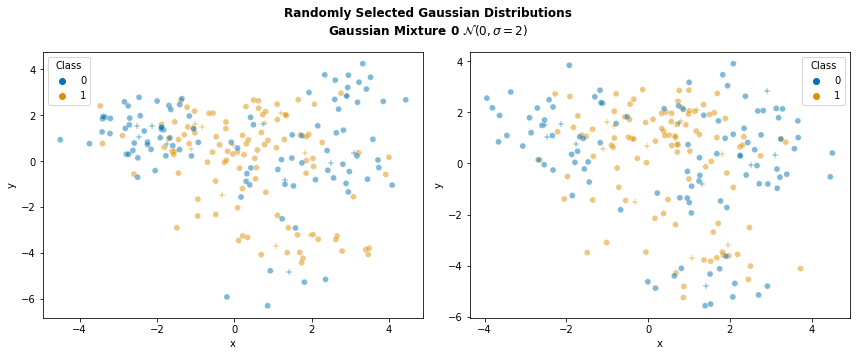

In [17]:
learner.report_data()

### Performance
Each of the models were evaluated for accuracy and against the AUC metric and is as follows.

---


Training Error

________________________________________________________________________________


,count,mean,std,min,50%,max,Lower 95% CI,Upper 95% CI
Model,,,,,,,,
Linear Regression,20.0,0.46575,0.043476,0.365,0.4650,0.545,0.446696,0.484804
Logistic Regression,20.0,0.46500,0.043498,0.365,0.4625,0.545,0.445936,0.484064
Naive Bayes',20.0,0.29925,0.026121,0.260,0.2925,0.350,0.287802,0.310698
Quadratic Regression,20.0,0.30600,0.028956,0.260,0.3025,0.370,0.293310,0.318690
kNN CV,20.0,0.51475,0.039917,0.425,0.5075,0.625,0.497256,0.532244


Test Error

________________________________________________________________________________


,count,mean,std,min,50%,max,Lower 95% CI,Upper 95% CI
Model,,,,,,,,
Linear Regression,20.0,0.491935,0.020819,0.4627,0.49045,0.5272,0.482810,0.501060
Logistic Regression,20.0,0.491900,0.020667,0.4621,0.48970,0.5272,0.482842,0.500958
Naive Bayes',20.0,0.292550,0.004751,0.2853,0.29235,0.3007,0.290468,0.294632
Quadratic Regression,20.0,0.312860,0.008083,0.2961,0.31470,0.3256,0.309318,0.316402
kNN CV,20.0,0.521130,0.022875,0.4956,0.51190,0.5695,0.511104,0.531156


Training AUC

________________________________________________________________________________


,count,mean,std,min,50%,max,Lower 95% CI,Upper 95% CI
Model,,,,,,,,
Linear Regression,20.0,0.562535,0.046096,0.4920,0.5650,0.6464,0.542332,0.582738
Logistic Regression,20.0,0.535000,0.043498,0.4550,0.5375,0.6350,0.515936,0.554064
Naive Bayes',20.0,0.700750,0.026121,0.6500,0.7075,0.7400,0.689302,0.712198
Quadratic Regression,20.0,0.747345,0.030960,0.6967,0.7448,0.7996,0.733776,0.760914
kNN CV,20.0,0.485250,0.039917,0.3750,0.4925,0.5750,0.467756,0.502744


Test AUC

________________________________________________________________________________


,count,mean,std,min,50%,max,Lower 95% CI,Upper 95% CI
Model,,,,,,,,
Linear Regression,20.0,0.528138,0.025678,0.444729,0.533060,0.560544,0.516885,0.539392
Logistic Regression,20.0,0.508100,0.020667,0.472800,0.510300,0.537900,0.499042,0.517158
Naive Bayes',20.0,0.707450,0.004751,0.699300,0.707650,0.714700,0.705368,0.709532
Quadratic Regression,20.0,0.734156,0.011173,0.702406,0.736055,0.750059,0.729259,0.739053
kNN CV,20.0,0.478870,0.022875,0.430500,0.488100,0.504400,0.468844,0.488896


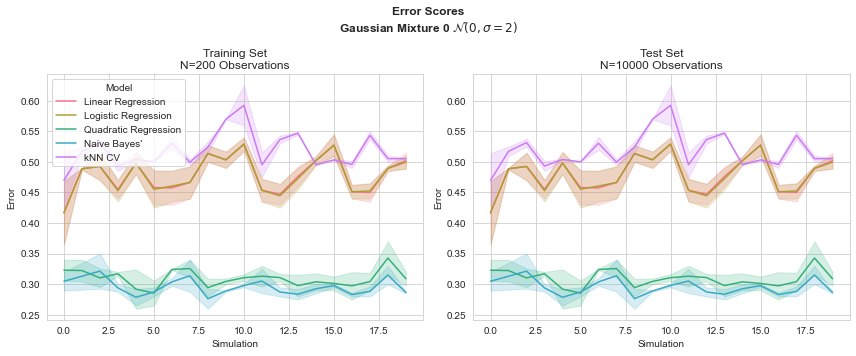

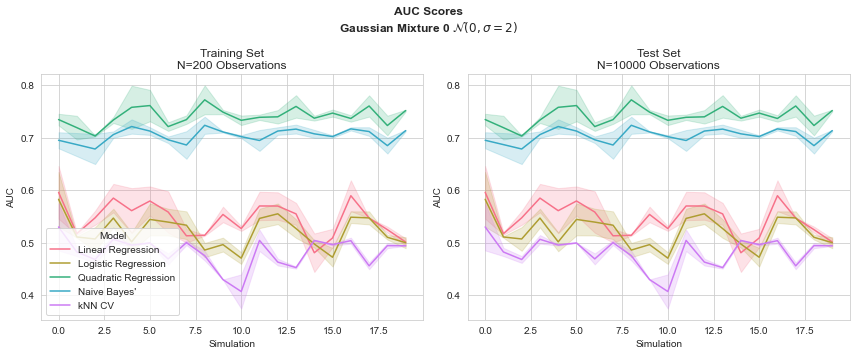

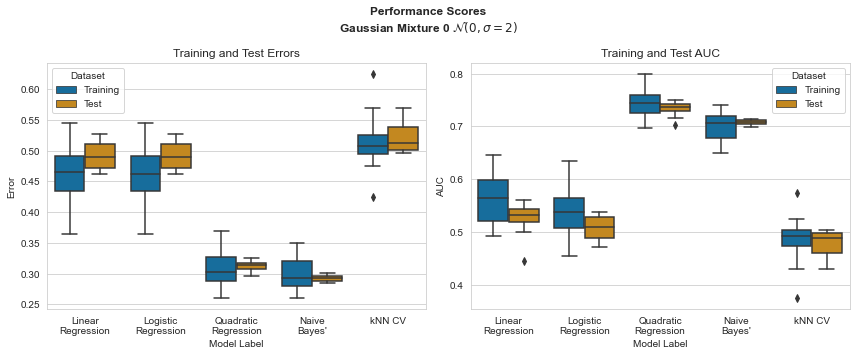

In [18]:
learner.report_scores()

Naive Bayes' and quadratic regression outperformed kNN, linear regression and logistic regression signficantly. 

### K Nearest Neighbors
Here we have the distribution of optimal k-values chosen by 10-fold Cross-Validation.

---



Descriptive Statistics for K Values Chosen by 10-Fold CV

________________________________________________________________________________


,count,mean,std,min,50%,max,Lower 95% CI,Upper 95% CI
Best k,20.0,158.65,13.087861,127.0,157.5,179.0,152.913992,164.386008


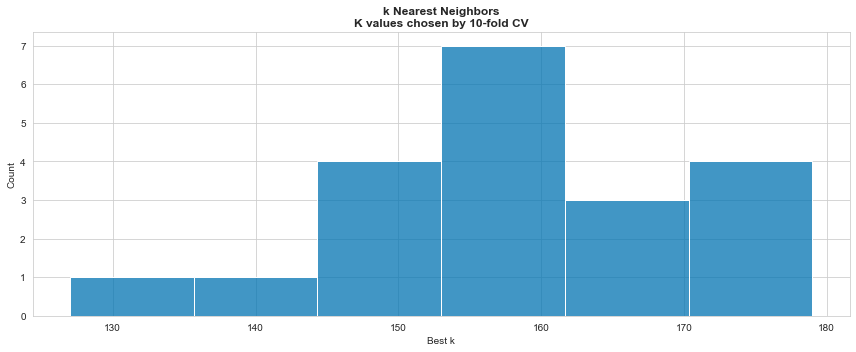

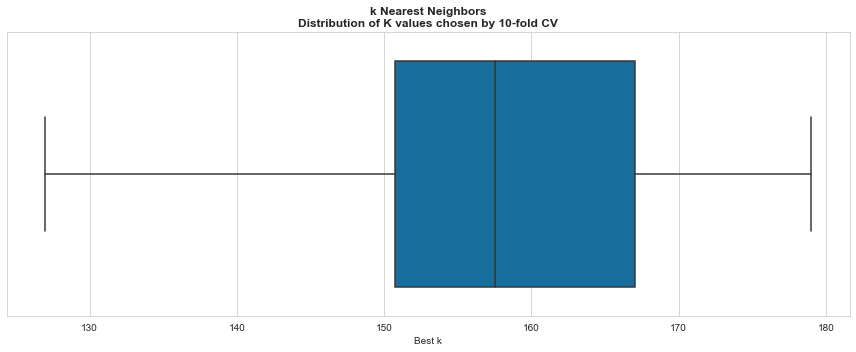

In [19]:
learner.report_k_values()

## Conclusion
In this notebook, we provide comparison of the prediction performance of five of widely used machine learning algorithms. In short, Naive Bayes' and Quadratic Regression outperformed Linear Regression, Logistic Regression and k-Nearest Neighbors by a significant margin. Outperforming Logistic Regression, a classifier purpose made for binary classification, was a surprising result. 

Future work would include a wider range of data distributions, data set dimensions, various levels of collinearity and interaction among the features.  Time complexity and memory consumption are also factors that should be considered in any algorithm comparative study.